In [13]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import joblib
import pickle

from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from sklearn import metrics

In [2]:
def image_to_df(snow_path, mask_path, print_gabor=False, labeled=True):
    #load in images
    img = cv2.imread(snow_path)
    if labeled:
        mask = rasterio.open(mask_path)
    
    #generate grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #flatten image
    img2 = img.reshape((-1,3))

    #create dataframe
    df = pd.DataFrame(img2, columns=['B', 'G', 'R'])
    df['gray'] = gray.reshape(-1)

    #gabor filter
    num = 1
    kernels = []
    for theta in range(2):
        theta = theta / 4. * np.pi
        for sigma in (1,3):
            for lamda in np.arange(0, np.pi, np.pi/4):
                for gamma in (.05, .5):
                    gabor_label = 'Gabor' + str(num)
                    ksize = 9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                    kernels.append(kernel)

                    fimg = cv2.filter2D(gray, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img
                    if print_gabor:
                        print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                    num += 1
    #Canny Edge
    edges = cv2.Canny(gray, 100, 200).reshape(-1)
    df['Canny Edge'] = edges

    #Roberts Edge
    roberts_edge = roberts(gray).reshape(-1)
    df['Roberts'] = roberts_edge

    #Sobel Edge
    sobel_edge = sobel(gray).reshape(-1)
    df['Sobel'] = sobel_edge

    #Scharr Edge
    scharr_edge = scharr(gray).reshape(-1)
    df['Scharr'] = scharr_edge

    #Prewitt Edge
    prewitt_edge = prewitt(gray).reshape(-1)
    df['Prewitt'] = prewitt_edge

    gaussian_img = nd.gaussian_filter(gray, sigma=3).reshape(-1)
    df['Gaussian s3'] = gaussian_img

    gaussian_img2 = nd.gaussian_filter(gray, sigma=7).reshape(-1)
    df['Gaussian s7'] = gaussian_img2

    median_img =  nd.median_filter(gray, size=3).reshape(-1)
    df['Median s3'] = median_img

    #labels
    if labeled:
        df['labels'] = mask.read(1).reshape(-1)

    return df

In [3]:
def visualize(img, mask, pred_image, accuracy = None, confusion_matrix = None, location=None, date=None):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Display original image
    axs[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Original Image')

    # Display mask
    axs[0, 1].imshow(mask.read(1), cmap='gray')
    axs[0, 1].set_title('Mask')

    # Display predicted image
    axs[1, 0].imshow(pred_image, cmap='jet')
    axs[1, 0].set_title('Predicted Image')

    # Display confusion matrix as table (if provided)
    if confusion_matrix is not None:
        axs[1, 1].axis('tight')
        axs[1, 1].axis('off')

        #change everything to percents
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

        #multiply by 100 and round to 4 decimal places, then convert to strings and add % sign
        confusion_matrix = np.round(confusion_matrix * 100, 3).astype(str)
        confusion_matrix = np.char.add(confusion_matrix, '%')
        
        # Create the table
        table_data = [[''] + [f'Pred {i}' for i in range(confusion_matrix.shape[1])]]  # Header row
        for i in range(confusion_matrix.shape[0]):
            row = [f'True {i}'] + list(confusion_matrix[i])
            table_data.append(row)
        
        # Add the table to the subplot
        table = axs[1, 1].table(cellText=table_data, loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.2)
        table.auto_set_column_width([0,1])
        axs[1, 1].set_title('Confusion Matrix')
        
        # Add accuracy text near the confusion matrix
        if accuracy is not None:
            axs[1, 1].text(0.5, -0.1, f'Accuracy: {accuracy}', horizontalalignment='center', verticalalignment='center', fontsize=12, transform=axs[1, 1].transAxes)
    elif accuracy is not None:
        # Display accuracy text in place of confusion matrix
        axs[1, 1].text(0.5, 0.5, f'Accuracy: {accuracy}', horizontalalignment='center', verticalalignment='center', fontsize=12)
        axs[1, 1].axis('off')
    else:
        axs[1, 1].text(0.5, 0.5, 'No Confusion Matrix or Accuracy Provided', horizontalalignment='center', verticalalignment='center', fontsize=12)
        axs[1, 1].axis('off')

    if location is not None and date is not None:
        plt.suptitle(f'Location: {location}, Date: {date}')
    elif location is not None:
        plt.suptitle(f'Location: {location}')
    elif date is not None:
        plt.suptitle(f'Date: {date}')

    plt.tight_layout()
    plt.show()

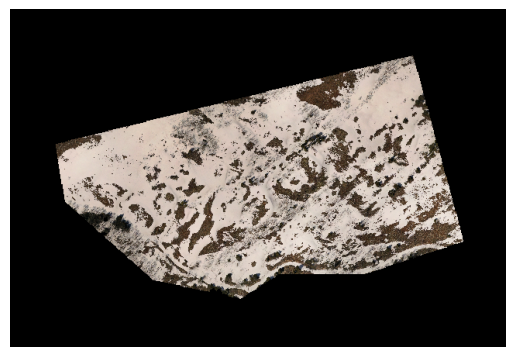

In [10]:
import os
import random

#open a random image in data/640/ that ends in snow.tif
# Path to the directory containing the images
image_dir = 'data/640/'

# Get a list of all files in the directory
files = os.listdir(image_dir)

# Filter the files to only include those ending with 'snow.tif'
snow_files = [file for file in files if file.endswith('snow.tif')]

# Select a random image from the snow files
random_image = random.choice(snow_files)

# Open the random image
image_path = os.path.join(image_dir, random_image)
img = cv2.imread(image_path)

# Display the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [11]:
#using joblib, open the model
model = joblib.load('640_RF_model_1.joblib')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.7s finished


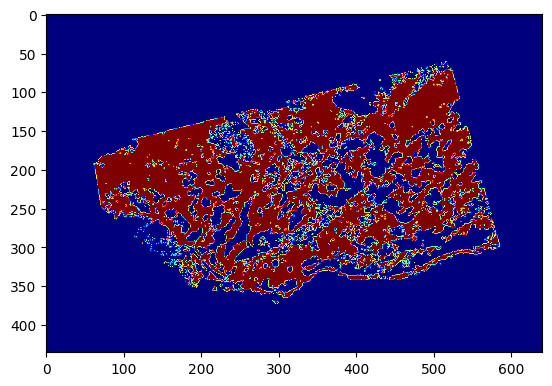

In [36]:
#run predict on the image, display the prediction
pred_image = model.predict(image_to_df(image_path, None, print_gabor=False, labeled=False))
pred_image = pred_image.reshape(img.shape[:2])

plt.imshow(pred_image, cmap='jet')



C:\Users\apfox\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished


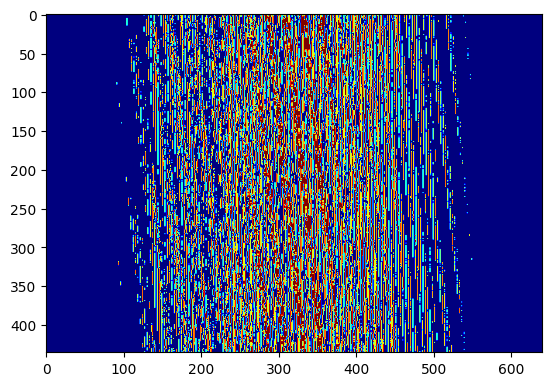

In [43]:
image_df = image_to_df(image_path, None, print_gabor=False, labeled=False)

#reshape into image
reshaped_df = np.array(image_df).reshape(img.shape[0], img.shape[1], -1)

#rotate the image
rotated_df = np.rot90(reshaped_df, 1)


#flatten
flattened_df = rotated_df.reshape(-1, rotated_df.shape[2])

#predict
pred_rot_image = model.predict(flattened_df)
pred_rot_image = pred_image.reshape(rotated_df.shape[:2])

#rotate back
pred_rot_image = np.rot90(pred_rot_image, -1)

plt.imshow(pred_rot_image, cmap='jet')

ValueError: operands could not be broadcast together with shapes (436,640) (640,436) 

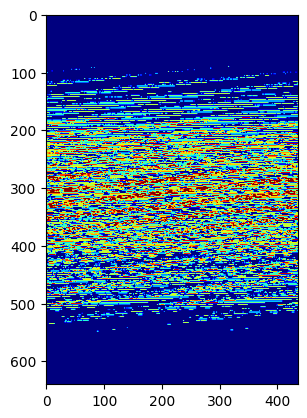

(array([0, 1]), array([ 87264, 191776], dtype=int64))

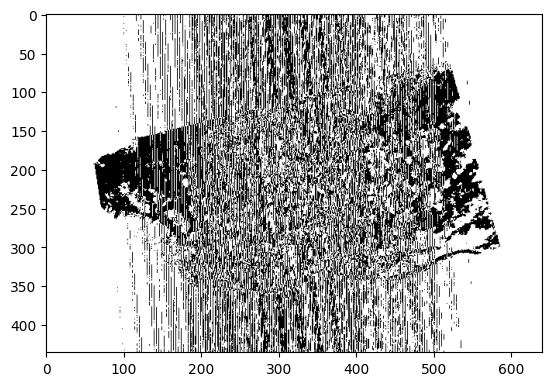

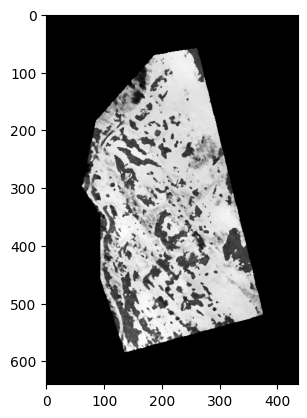

In [88]:
#lets try rotating the image first, then saving it and opeing it with the preprocessing
#load in image, rotate
img = cv2.imread(image_path)
rotated_img = np.rot90(img, 3)

#save the rotated image
cv2.imwrite('rotated_img.tif', rotated_img)

#open the rotated image with the preprocessing
rotated_image_df = image_to_df('rotated_img.tif', None, print_gabor=False, labeled=False)

#reshape into image
reshaped_df = np.array(rotated_image_df).reshape(rotated_img.shape[0], rotated_img.shape[1], -1)

#roate back
# rotated_df = np.rot90(reshaped_df, 3)

#visualize gabor filter
plt.imshow(reshaped_df[:,:,43], cmap='gray')


(279040, 44)


C:\Users\apfox\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.8s finished


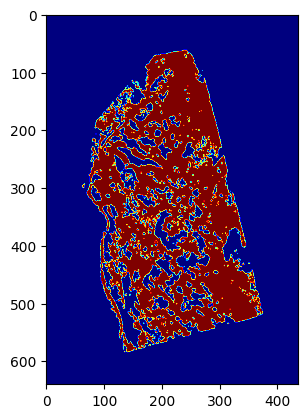

In [96]:

#flatten
flattened_df = reshaped_df.reshape(-1, reshaped_df.shape[2])
print(flattened_df.shape)

#predict
pred_rot_image = model.predict(flattened_df)
pred_rot_image = pred_rot_image.reshape(reshaped_df.shape[:2])

#visualize prediction
plt.imshow(pred_rot_image, cmap='jet')

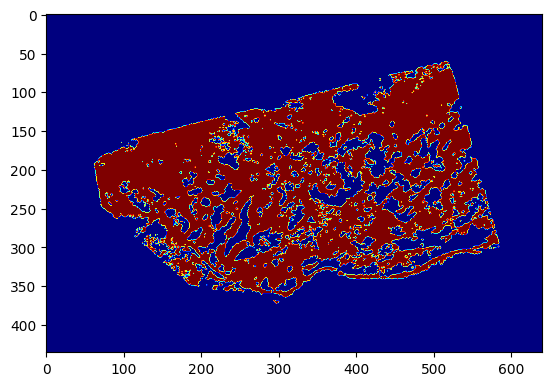

In [97]:
#rotate the pred image back
pred_rot_image_back = np.rot90(pred_rot_image, 1)
#visualize rotated image
plt.imshow(pred_rot_image_back, cmap='jet')

#create array that says where they agree
agreement_array = np.where(pred_image ^ pred_rot_image_back, 0, 1)

(array([0, 1]), array([ 14732, 264308], dtype=int64))

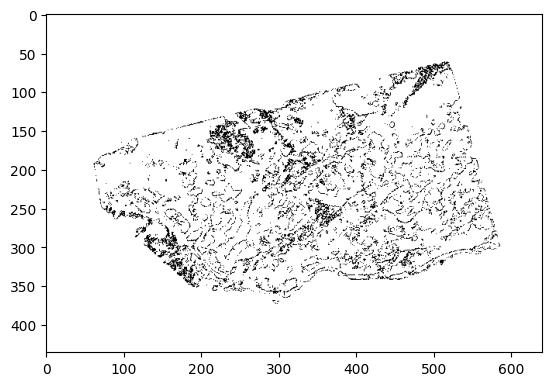

In [98]:
#visualize agreement array
plt.imshow(agreement_array, cmap='gray')

#find unique values and counts of agrrement array
np.unique(agreement_array, return_counts=True)
